In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import gpytorch

from utils.kernels import (
    SquaredExponential,
    AbsoluteExponential
)

In [3]:
torch.set_default_dtype(torch.float64) # use double precision
_ = torch.manual_seed(7777) # set random seed manually

In [4]:
lower = -10
upper = 10
num_coords = 101

coords = torch.linspace(lower, upper, num_coords)

In [5]:
sigma = 1 # standard deviation
length = 1 # lengthscale parameter

kernel_rbf = SquaredExponential(sigma, length)
kernel_ou = AbsoluteExponential(sigma, length)

In [6]:
nu = 2.5 # smoothness parameter

kernel_matern = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=nu)
)

kernel_matern.outputscale = sigma
kernel_matern.base_kernel.lengthscale = length

for p in kernel_matern.parameters():
    p.requires_grad = False

In [7]:
x_values = torch.linspace(coords.min(), coords.max(), 1001)

y_values_rbf = kernel_rbf.kernel(x_values)
y_values_ou = kernel_ou.kernel(x_values)
y_values_matern = kernel_matern(x_values, x_values).evaluate()[x_values.abs().argmin()]

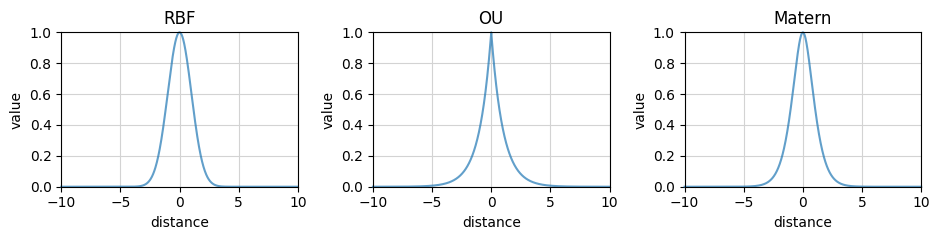

In [8]:
kernel_dict = {
    'RBF': y_values_rbf,
    'OU': y_values_ou,
    'Matern': y_values_matern
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.5, 2.5))
for ax, (key, y_values) in zip(axes.ravel(), kernel_dict.items()):
    ax.plot(x_values.numpy(), y_values.numpy(), alpha=0.7, clip_on=False)
    ax.set(xlabel='distance', ylabel='value')
    ax.set_xlim((x_values.min(), x_values.max()))
    ax.set_ylim((0, y_values.max()))
    ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
    ax.set_title(key)
fig.tight_layout()

In [9]:
cov_rbf = kernel_rbf(coords, coords)
cov_ou = kernel_ou(coords, coords)
cov_matern = kernel_matern(coords, coords).evaluate()

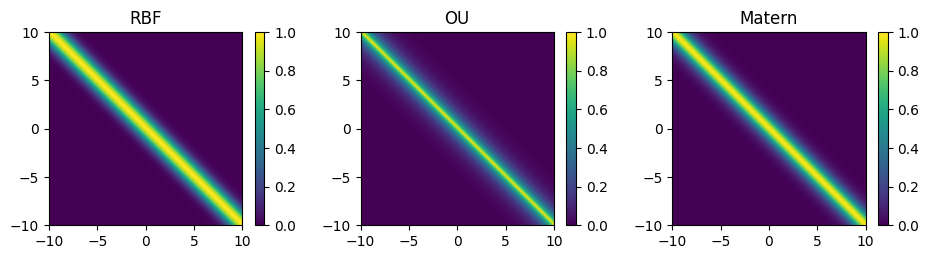

In [10]:
cov_dict = {
    'RBF': cov_rbf,
    'OU': cov_ou,
    'Matern': cov_matern
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.5, 2.5))
for ax, (key, cov) in zip(axes.ravel(), cov_dict.items()):
    img = ax.imshow(
        cov.numpy(),
        cmap='viridis',
        aspect='equal',
        interpolation='bilinear',
        vmin=0,
        origin='upper',
        extent=(lower, upper, lower, upper)
    )
    ax.set_title(key)
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [11]:
num_samples = 10

samples_rbf = dist.MultivariateNormal(
    loc=torch.zeros_like(coords),
    covariance_matrix=cov_rbf + 1e-07*torch.eye(num_coords) # add nugget
).sample((num_samples,))

samples_ou = dist.MultivariateNormal(
    loc=torch.zeros_like(coords),
    covariance_matrix=cov_ou + 1e-07*torch.eye(num_coords) # add nugget
).sample((num_samples,))

samples_matern = dist.MultivariateNormal(
    loc=torch.zeros_like(coords),
    covariance_matrix=cov_matern
).sample((num_samples,))

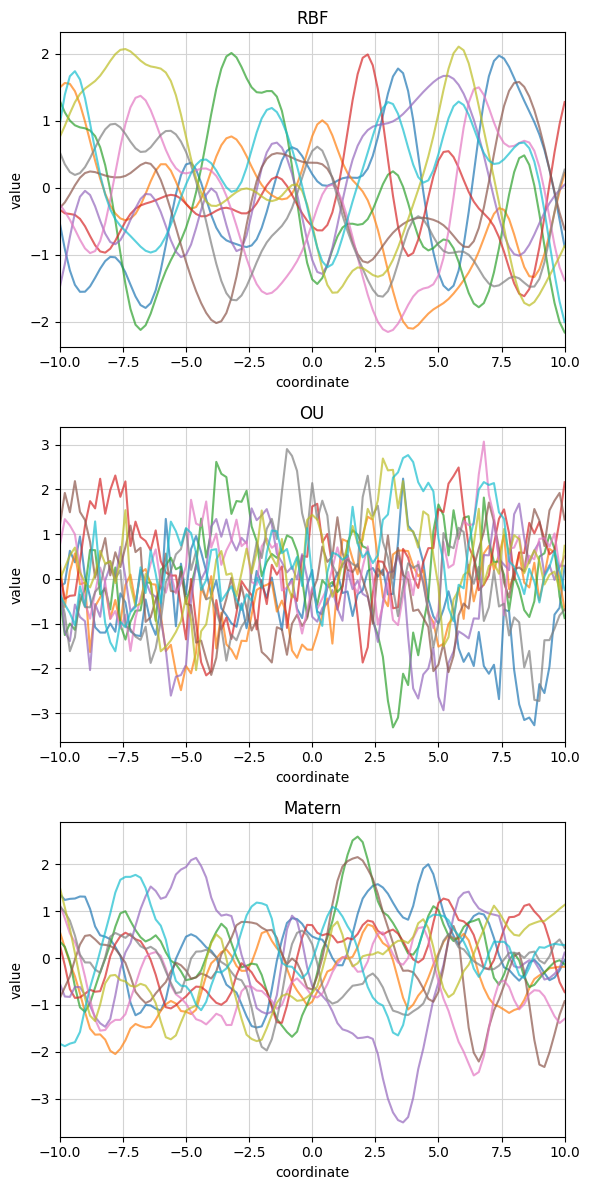

In [12]:
samples_dict = {
    'RBF': samples_rbf,
    'OU': samples_ou,
    'Matern': samples_matern
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))
for ax, (key, samples) in zip(axes.ravel(), samples_dict.items()):
    ax.plot(coords.numpy(), samples.T.numpy(), alpha=0.7)
    ax.set(xlabel='coordinate', ylabel='value')
    ax.set_xlim((coords.min(), coords.max()))
    ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
    ax.set_title(key)
fig.tight_layout()